# Non i.i.d. data

No aprendizado de máquina, é bastante comum assumir que os dados são iid, o que significa que o processo gerador não possui nenhuma memória de amostras anteriores para gerar novas amostras.

Essa suposição geralmente é violada ao lidar com séries temporais. Uma amostra depende de informações anteriores.

Tomaremos um exemplo para destacar esses problemas com dados não-iid nas estratégias de validação cruzada apresentadas anteriormente. Vamos carregar cotações financeiras de algumas empresas de energia.

In [1]:
import pandas as pd

symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
url = ("https://raw.githubusercontent.com/scikit-learn/examples-data/"
       "master/financial-data/{}.csv")

quotes = {}
for symbol in symbols:
    data = pd.read_csv(url.format(symbol), index_col=0, parse_dates=True)
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

In [2]:
quotes.head()

,Total,Exxon,Chevron,ConocoPhillips,Valero Energy
date,,,,,
2003-01-02,71.62,35.00,67.20,48.80,37.04
2003-01-03,72.12,35.25,67.82,49.53,38.13
2003-01-06,72.93,35.45,68.34,49.50,37.37
2003-01-07,72.40,36.05,69.75,49.85,37.46
2003-01-08,69.51,35.15,68.46,48.44,36.51


Podemos começar traçando as diferentes cotações financeiras.

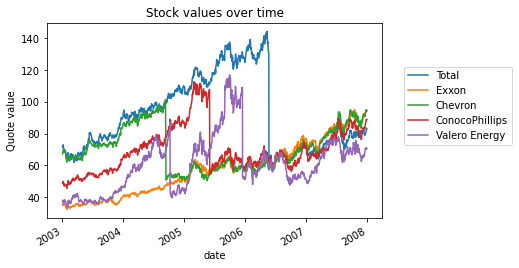

In [3]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Stock values over time")

Vamos repetir a experiência solicitada durante o exercício. Em vez de usar dados aleatórios, usaremos cotações reais desta vez. Embora fosse óbvio que um modelo preditivo não funcionaria na prática com dados aleatórios, o mesmo ocorre com esses dados reais. Portanto, aqui, queremos prever a cotação da Chevron usando as cotações de todas as outras empresas de energia.

Para fazer gráficos explicativos, usaremos uma única divisão além da validação cruzada que você usou no exercício introdutório.

In [4]:
from sklearn.model_selection import train_test_split

data, target = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0)

Usaremos um regressor de árvore de decisão que esperamos ajustar e, portanto, não generalizar para dados invisíveis. Usaremos uma `ShuffleSplit` validação cruzada para verificar o desempenho de generalização de nosso modelo.

Vamos primeiro definir nosso modelo

In [5]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

E agora a estratégia de validação cruzada.

In [6]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0)

Por fim, fazemos a avaliação.

In [7]:
from sklearn.model_selection import cross_val_score

test_score = cross_val_score(regressor, data_train, target_train, cv=cv,
                             n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: 0.95 +/- 0.07


Surpreendentemente, obtemos excelente desempenho de generalização. Investigaremos e encontraremos a razão para esses bons resultados com um modelo que provavelmente falhará. Mencionamos anteriormente que `ShuffleSplit` é um esquema de validação cruzada iterativo que embaralha e divide os dados. Vamos simplificar este procedimento com uma única divisão e representar graficamente a previsão. Podemos usar `train_test_split` para esse fim.

In [8]:
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
# Affect the index of `target_predicted` to ease the plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)

Vamos verificar o desempenho de generalização de nosso modelo nesta divisão.

In [9]:
from sklearn.metrics import r2_score

test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: 0.82


Da mesma forma, obtemos bons resultados em termos de $R^2$. Faremos um gráfico das amostras de treinamento, teste e previsão.

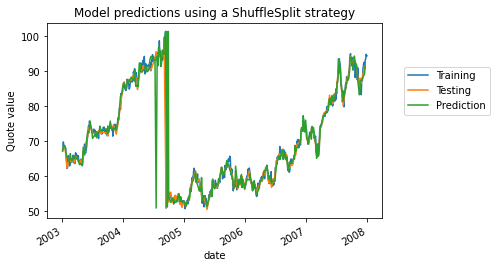

In [10]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a ShuffleSplit strategy")

Portanto, neste contexto, parece que as previsões do modelo estão seguindo os testes. Mas também podemos ver que as amostras de teste estão próximas a alguma amostra de treinamento. E com essas séries temporais, vemos uma relação entre uma amostra no momento `t` e uma amostra em `t+1`. Nesse caso, estamos violando a suposição de iid. O insight a ser obtido é o seguinte: um modelo pode produzir seu conjunto de treinamento no momento `t` para uma amostra de teste no momento `t+1`. Essa previsão estaria próxima do valor verdadeiro mesmo se nosso modelo não aprendesse nada, mas apenas memorizasse o conjunto de dados de treinamento.

Uma maneira fácil de verificar essa hipótese é não embaralhar os dados ao fazer a divisão. Nesse caso, usaremos os primeiros 75% dos dados para treinar e os dados restantes para testar.

In [11]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=False, random_state=0,
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [12]:
test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.22


Nesse caso, vemos que nosso modelo não é mais mágico. Na verdade, ele tem um desempenho pior do que apenas prever a média do alvo. Podemos verificar visualmente o que estamos prevendo.

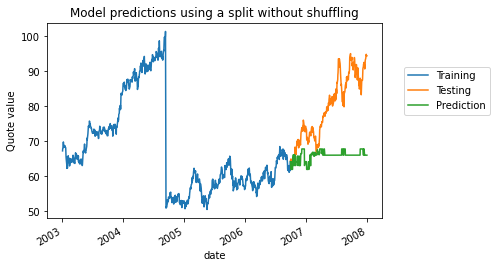

In [13]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a split without shuffling")

Vemos que nosso modelo não pode prever nada porque não tem amostras em torno da amostra de teste. Vamos verificar como poderíamos ter feito um esquema de validação cruzada adequado para obter uma estimativa de desempenho de generalização razoável.

Uma solução seria agrupar as amostras em blocos de tempo, por exemplo, por trimestre, e prever as informações de cada grupo usando as informações dos outros grupos. Podemos usar a `LeaveOneGroupOut` validação cruzada para esse propósito.

In [14]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: -0.93 +/- 1.72


Nesse caso, vemos que não podemos fazer boas previsões, o que é menos surpreendente do que nossos resultados originais.

Outra coisa a se considerar é a aplicação real de nossa solução. Se nosso modelo tem como objetivo a previsão (ou seja, prever dados futuros a partir de dados anteriores), não devemos usar dados de treinamento posteriores aos dados de teste. Nesse caso, podemos usar a `TimeSeriesSplit` validação cruzada para impor esse comportamento.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: -1.47 +/- 1.94


Em conclusão, é realmente importante não usar uma estratégia de validação cruzada fora das prateleiras que não respeite algumas suposições, como ter dados iid. Isso pode levar a resultados absurdos que podem fazer pensar que um modelo preditivo pode funcionar.